In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import os

# 📁 Define paths
base_path = "F:/Freelancing/WildFire_Paper_CA/GEE/Fire_Risk_CA_2025"
save_dir = base_path
os.makedirs(save_dir, exist_ok=True)

# 📄 Load model validation CSVs (only RF & SVM)
df_rf = pd.read_csv(os.path.join(base_path, "FireRisk_Validation_RF_AUC.csv"))
df_svm = pd.read_csv(os.path.join(base_path, "FireRisk_Validation_SVM_AUC.csv"))

# 🔧 Classification threshold
threshold = 0.5

# 📊 Function to evaluate model and return metrics + ROC data
def evaluate_model(df, model_name):
    y_true = df['class']
    y_prob = df['probability']
    y_pred = (y_prob >= threshold).astype(int)

    # 🔹 Metrics
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n📊 {model_name} Performance:")
    print(f"AUC: {auc:.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
    print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))

    # 🔹 Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Fire", "Fire"],
                yticklabels=["No Fire", "Fire"])
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    cm_path = os.path.join(save_dir, f"{model_name.replace(' ', '_')}_Confusion_Matrix.png")
    plt.savefig(cm_path, dpi=300)
    plt.close()
    print(f"✅ Saved confusion matrix to: {cm_path}")

    # 🔹 ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)

    return {
        "model": model_name,
        "AUC": auc,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "FPR": fpr,
        "TPR": tpr
    }

# Evaluate models
metrics_rf = evaluate_model(df_rf, "Random Forest")
metrics_svm = evaluate_model(df_svm, "SVM")

# 🔁 Combine metrics
metrics_df = pd.DataFrame([
    {k: v for k, v in m.items() if k not in ['FPR', 'TPR']}
    for m in [metrics_rf, metrics_svm]
])

# 💾 Save metrics summary CSV
metrics_csv_path = os.path.join(save_dir, "Model_Performance_Summary_RF_SVM.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"✅ Exported model performance metrics to: {metrics_csv_path}")

# 📈 ROC Curve Comparison (RF vs SVM only)
plt.figure(figsize=(8, 6))
plt.plot(metrics_rf['FPR'], metrics_rf['TPR'], label=f"RF (AUC = {metrics_rf['AUC']:.2f})", color='green')
plt.plot(metrics_svm['FPR'], metrics_svm['TPR'], label=f"SVM (AUC = {metrics_svm['AUC']:.2f})", color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🔥 ROC Curve Comparison: RF vs SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# 💾 Save ROC plot
roc_plot_path = os.path.join(save_dir, "ROC_Comparison_RF_SVM.png")
plt.savefig(roc_plot_path, dpi=300)
plt.close()
print(f"✅ Saved ROC curve comparison to: {roc_plot_path}")



📊 Random Forest Performance:
AUC: 0.998, Accuracy: 0.973, Precision: 0.979, Recall: 0.960, F1: 0.969
              precision    recall  f1-score   support

     No Fire       0.97      0.98      0.98       183
        Fire       0.98      0.96      0.97       149

    accuracy                           0.97       332
   macro avg       0.97      0.97      0.97       332
weighted avg       0.97      0.97      0.97       332

✅ Saved confusion matrix to: F:/Freelancing/WildFire_Paper_CA/GEE/Fire_Risk_CA_2025\Random_Forest_Confusion_Matrix.png

📊 SVM Performance:
AUC: 0.298, Accuracy: 0.346, Precision: 0.344, Recall: 0.503, F1: 0.409
              precision    recall  f1-score   support

     No Fire       0.35      0.22      0.27       183
        Fire       0.34      0.50      0.41       149

    accuracy                           0.35       332
   macro avg       0.35      0.36      0.34       332
weighted avg       0.35      0.35      0.33       332

✅ Saved confusion matrix to: F:/F

C:\Users\PC\AppData\Local\Temp\ipykernel_20376\3050188303.py:90: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\PC\AppData\Local\Temp\ipykernel_20376\3050188303.py:94: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig(roc_plot_path, dpi=300)


✅ Saved ROC curve comparison to: F:/Freelancing/WildFire_Paper_CA/GEE/Fire_Risk_CA_2025\ROC_Comparison_RF_SVM.png


In [3]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# 📂 Paths
input_csv = r"F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv"
output_dir = r"F:\Freelancing\WildFire_Paper_CA\Excels_Results"
os.makedirs(output_dir, exist_ok=True)

# 1️⃣ Load training data
df = pd.read_csv(input_csv)
df = df.drop(columns=['system:index', '.geo'], errors='ignore')

# 2️⃣ Split features and labels
X = df.drop(columns=['class'])
y = df['class']

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ Train SVM model
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

# 6️⃣ Use SHAP KernelExplainer (for SVMs)
explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100])  # list of arrays: [class0, class1]

# Debug shapes
print(f"✅ SHAP shape: {np.array(shap_values).shape}")  
print(f"✅ X_test shape: {X_test_scaled[:100].shape}")
print(f"✅ Features: {list(X.columns)}")

# 🔹 Extract SHAP values for class 1 (Fire)
shap_class1 = np.array(shap_values)[:, :, 1]  # shape (100, n_features)

# 📊 SHAP summary plot (bar)
shap.summary_plot(
    shap_class1,
    features=X_test_scaled[:100],
    feature_names=X.columns,
    plot_type='bar',
    show=False
)
plt.title("SHAP Feature Importance (Bar) - SVM")
plt.tight_layout()
bar_path = os.path.join(output_dir, "shap_feature_importance_bar_SVM.png")
plt.savefig(bar_path, dpi=300)
plt.close()
print(f"📊 SHAP bar plot saved to: {bar_path}")

# 📄 Save SHAP feature importance to CSV
mean_abs_shap = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Abs_SHAP": np.abs(shap_class1).mean(axis=0)
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

csv_path = os.path.join(output_dir, "shap_feature_importance_SVM.csv")
mean_abs_shap.to_csv(csv_path, index=False)
print(f"✅ SHAP feature importance saved to: {csv_path}")

# 🐝 SHAP summary plot (beeswarm)
shap.summary_plot(
    shap_class1,
    features=X_test_scaled[:100],
    feature_names=X.columns,
    show=False
)
plt.title("SHAP Summary Plot (Beeswarm) - SVM")
plt.tight_layout()
swarm_path = os.path.join(output_dir, "shap_summary_beeswarm_SVM.png")
plt.savefig(swarm_path, dpi=300)
plt.close()
print(f"📊 SHAP beeswarm plot saved to: {swarm_path}")


  0%|          | 0/67 [00:00<?, ?it/s]

✅ SHAP shape: (67, 15, 2)
✅ X_test shape: (67, 15)
✅ Features: ['EVI', 'Elevation', 'LST', 'NDVI', 'Population', 'SOC_0cm', 'SOC_10cm', 'SOC_30cm', 'SWC_0cm', 'SWC_10cm', 'SWC_30cm', 'TreeCover', 'VCI', 'aspect', 'slope']
📊 SHAP bar plot saved to: F:\Freelancing\WildFire_Paper_CA\Excels_Results\shap_feature_importance_bar_SVM.png
✅ SHAP feature importance saved to: F:\Freelancing\WildFire_Paper_CA\Excels_Results\shap_feature_importance_SVM.csv
📊 SHAP beeswarm plot saved to: F:\Freelancing\WildFire_Paper_CA\Excels_Results\shap_summary_beeswarm_SVM.png


<>:9: SyntaxWarning: invalid escape sequence '\F'
<>:9: SyntaxWarning: invalid escape sequence '\F'
C:\Users\PC\AppData\Local\Temp\ipykernel_20376\4041578307.py:9: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv")


✅ SHAP shape: (67, 15, 2)
✅ X_test shape: (67, 15)
📊 SHAP bar plot saved to: F:/Freelancing/WildFire_Paper_CA/Excels_Results/shap_feature_importance_bar_RF.png
✅ SHAP feature importance saved to: F:/Freelancing/WildFire_Paper_CA/Excels_Results/shap_feature_importance_RF.csv


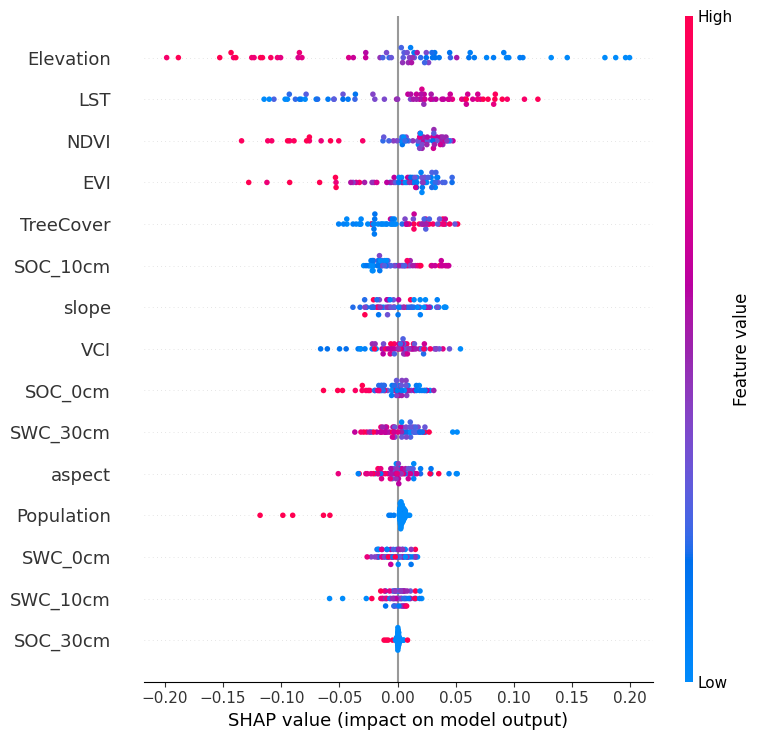

In [22]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Load training data
df = pd.read_csv("F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv")
df = df.drop(columns=['system:index', '.geo'], errors='ignore')

# 2. Split features and labels
X = df.drop(columns=['class'])
y = df['class']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Use SHAP TreeExplainer (faster & optimized for RF)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)  # list of arrays: [class0, class1]

# Confirm shape
print(f"✅ SHAP shape: {np.array(shap_values).shape}")  # Should be (2, n_samples, n_features)
print(f"✅ X_test shape: {X_test.shape}")

# Select SHAP values for class 1 (Fire)
shap_class1 = shap_values[:, :, 1]  # Shape (116, 15)

# Now plot
shap.summary_plot(
    shap_class1,
    features=X_test,
    feature_names=X.columns,
    plot_type='bar',
    show=False
)


plt.title("SHAP Feature Importance (Bar) - Random Forest")
plt.tight_layout()
bar_path = r"F:/Freelancing/WildFire_Paper_CA/Excels_Results/shap_feature_importance_bar_RF.png"
plt.savefig(bar_path, dpi=300)
plt.close()
print(f"📊 SHAP bar plot saved to: {bar_path}")

# ✅ Save SHAP feature importance to CSV
mean_abs_shap = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Abs_SHAP": np.abs(shap_class1).mean(axis=0)
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

csv_path = r"F:/Freelancing/WildFire_Paper_CA/Excels_Results/shap_feature_importance_RF.csv"
mean_abs_shap.to_csv(csv_path, index=False)
print(f"✅ SHAP feature importance saved to: {csv_path}")

# ✅ Optional summary plot (Bee Swarm)
shap.summary_plot(
    shap_class1,
    features=X_test,
    feature_names=X.columns
)


  0%|          | 0/67 [00:00<?, ?it/s]

✅ SHAP shape: (67, 15, 2)
✅ X_test shape: (67, 15)
✅ Features: ['EVI', 'Elevation', 'LST', 'NDVI', 'Population', 'SOC_0cm', 'SOC_10cm', 'SOC_30cm', 'SWC_0cm', 'SWC_10cm', 'SWC_30cm', 'TreeCover', 'VCI', 'aspect', 'slope']


<Figure size 640x480 with 0 Axes>

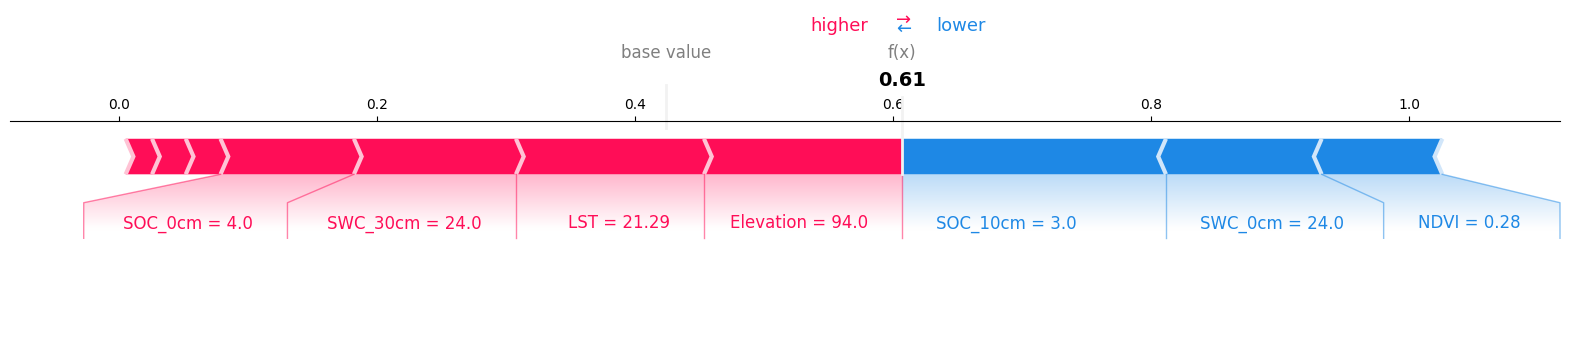

📌 Force plot saved: F:\Freelancing\WildFire_Paper_CA\Excels_Results_1\shap_force_plot_sample_1.png


<Figure size 640x480 with 0 Axes>

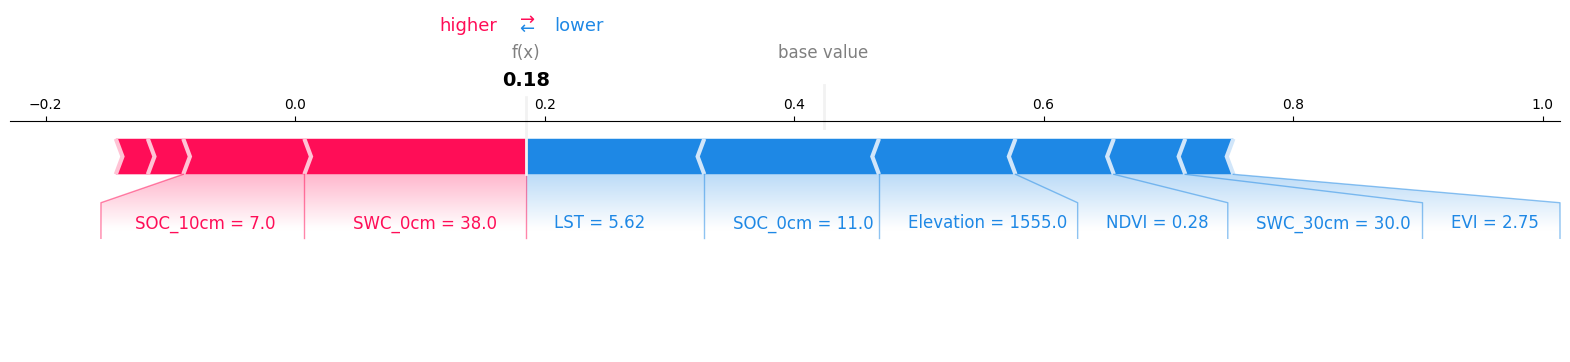

📌 Force plot saved: F:\Freelancing\WildFire_Paper_CA\Excels_Results_1\shap_force_plot_sample_2.png


<Figure size 640x480 with 0 Axes>

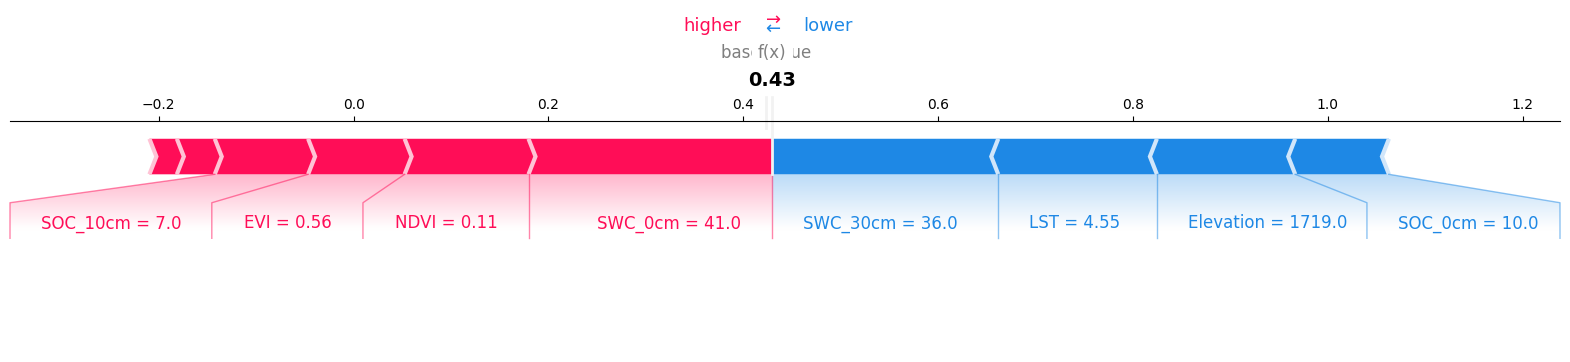

📌 Force plot saved: F:\Freelancing\WildFire_Paper_CA\Excels_Results_1\shap_force_plot_sample_3.png


<Figure size 640x480 with 0 Axes>

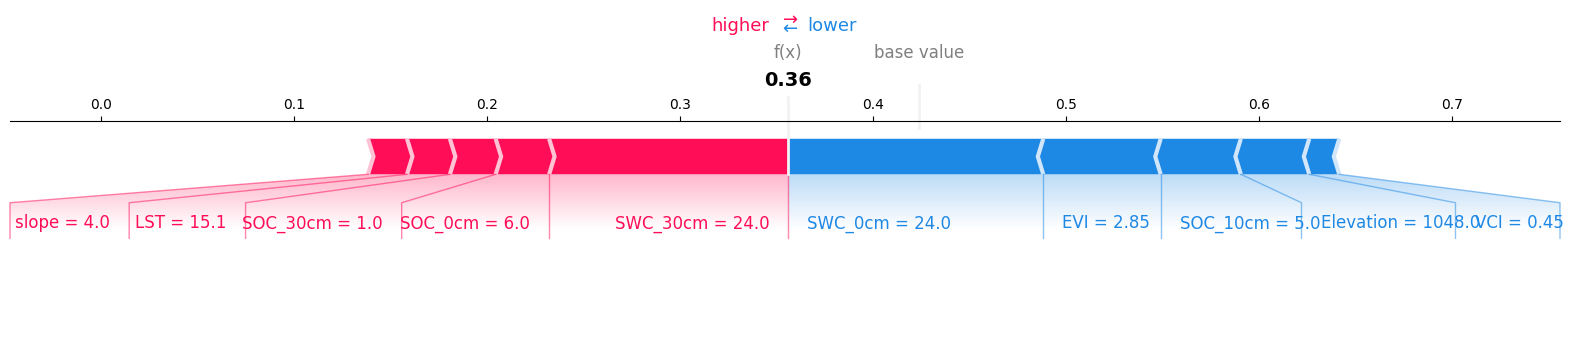

📌 Force plot saved: F:\Freelancing\WildFire_Paper_CA\Excels_Results_1\shap_force_plot_sample_4.png


<Figure size 640x480 with 0 Axes>

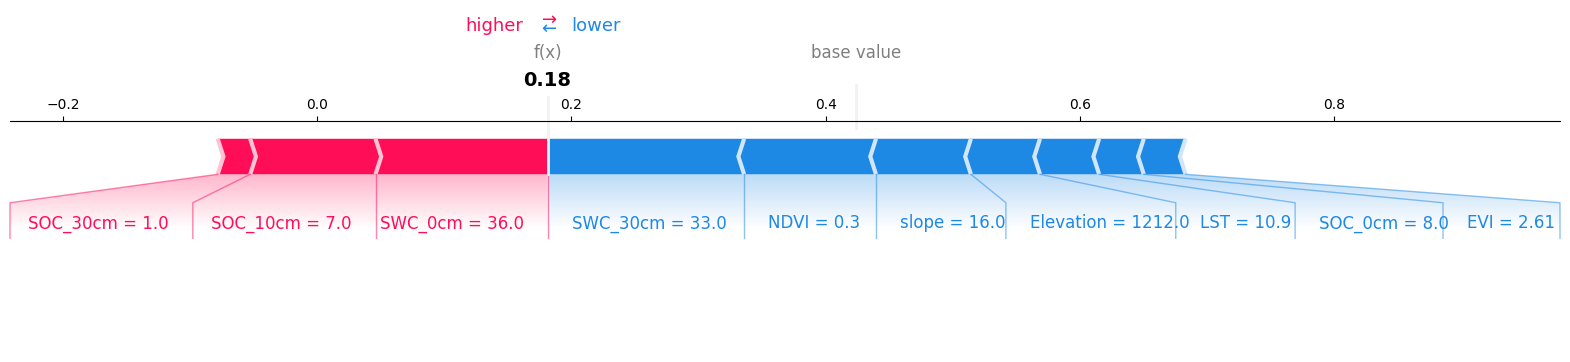

📌 Force plot saved: F:\Freelancing\WildFire_Paper_CA\Excels_Results_1\shap_force_plot_sample_5.png


In [4]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import os

# 📂 Paths
input_csv = r"F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv"
output_dir = r"F:\Freelancing\WildFire_Paper_CA\Excels_Results_1"
os.makedirs(output_dir, exist_ok=True)

# 1️⃣ Load training data
df = pd.read_csv(input_csv)
df = df.drop(columns=['system:index', '.geo'], errors='ignore')

# 2️⃣ Split features and labels
X = df.drop(columns=['class'])
y = df['class']

# 3️⃣ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4️⃣ Scale features for SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5️⃣ Train SVM model
model = SVC(kernel='linear', probability=True, random_state=42)
model.fit(X_train_scaled, y_train)

# 6️⃣ Use SHAP KernelExplainer (for SVMs)
explainer = shap.KernelExplainer(model.predict_proba, X_train_scaled[:50])
shap_values = explainer.shap_values(X_test_scaled[:100])  # list of arrays: [class0, class1]

# Debug shapes
print(f"✅ SHAP shape: {np.array(shap_values).shape}")  
print(f"✅ X_test shape: {X_test_scaled[:100].shape}")
print(f"✅ Features: {list(X.columns)}")

# 🔹 Extract SHAP values for class 1 (Fire)
shap_class1 = np.array(shap_values)[:, :, 1]  # shape (100, n_features)

# 📊 Save bar plot
shap.summary_plot(shap_class1, features=X_test_scaled[:100], feature_names=X.columns, plot_type='bar', show=False)
plt.title("SHAP Feature Importance (Bar) - SVM")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "shap_feature_importance_bar_SVM.png"), dpi=300)
plt.close()

# 📄 Save feature importance CSV
mean_abs_shap = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Abs_SHAP": np.abs(shap_class1).mean(axis=0)
}).sort_values(by="Mean_Abs_SHAP", ascending=False)
mean_abs_shap.to_csv(os.path.join(output_dir, "shap_feature_importance_SVM.csv"), index=False)

# 🐝 Beeswarm plot
shap.summary_plot(shap_class1, features=X_test_scaled[:100], feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot (Beeswarm) - SVM")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "shap_summary_beeswarm_SVM.png"), dpi=300)
plt.close()

# 🎯 SHAP Force Plots for Top 5 Samples (PNG) with values rounded to 2 decimals
for i in range(5):
    plt.figure()
    shap.force_plot(
        explainer.expected_value[1],         # Base value for class 1
        shap_class1[i, :],                   # SHAP values for sample i
        np.round(X_test.iloc[i, :], 2),      # ✅ Feature values rounded to 2 decimals
        feature_names=X.columns,
        matplotlib=True
    )
    plt.title(f"SHAP Force Plot - Sample {i+1}")
    plt.tight_layout()
    force_png_path = os.path.join(output_dir, f"shap_force_plot_sample_{i+1}.png")
    plt.savefig(force_png_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"📌 Force plot saved: {force_png_path}")


<>:9: SyntaxWarning: invalid escape sequence '\F'
<>:9: SyntaxWarning: invalid escape sequence '\F'
C:\Users\PC\AppData\Local\Temp\ipykernel_21764\440629053.py:9: SyntaxWarning: invalid escape sequence '\F'
  df = pd.read_csv("F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv")


✅ SHAP shape: (67, 15, 2)
✅ X_test shape: (67, 15)
📊 SHAP bar plot saved to: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/shap_feature_importance_bar_RF.png
✅ SHAP feature importance saved to: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/shap_feature_importance_RF.csv


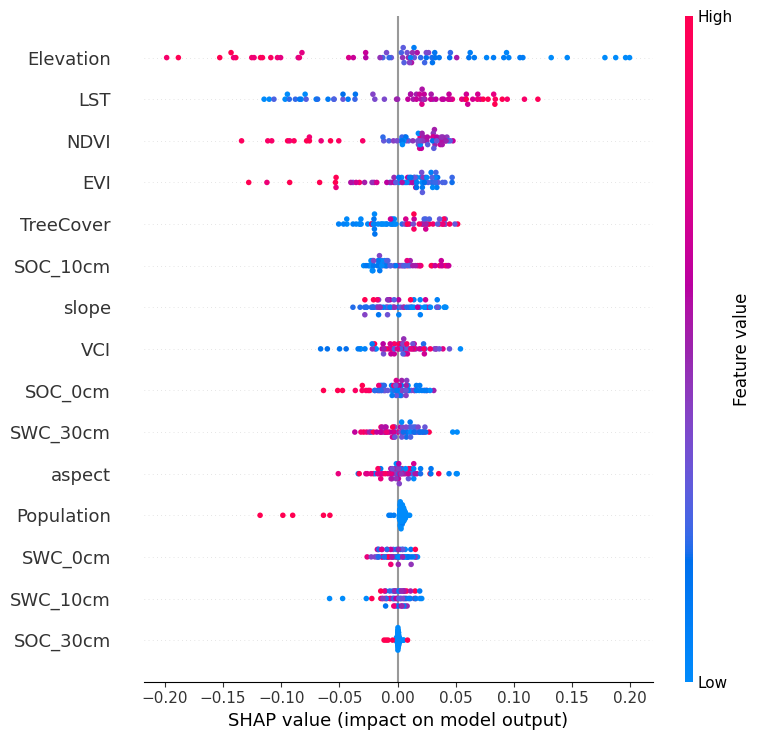

<Figure size 640x480 with 0 Axes>

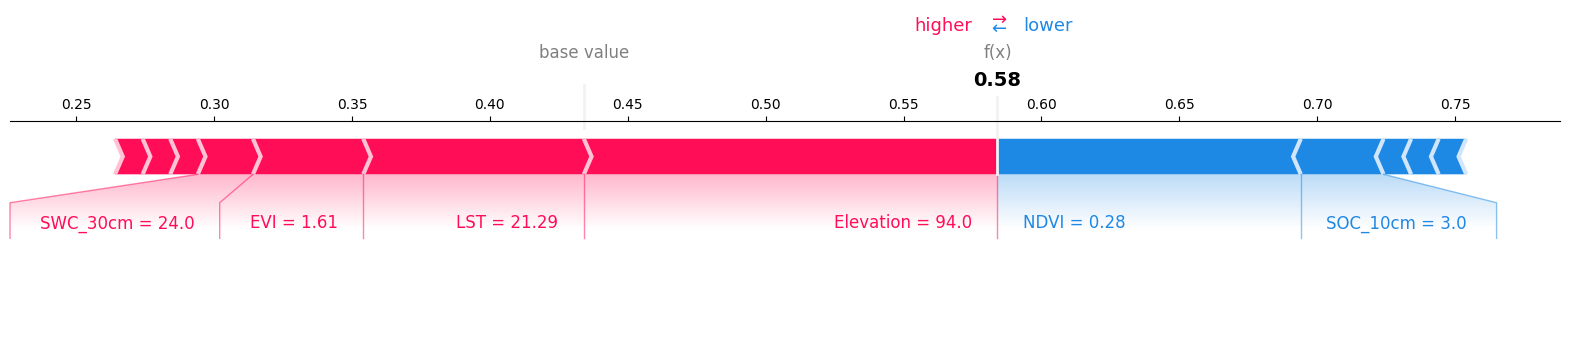

📌 Force plot saved: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots\shap_force_plot_sample_1.png


<Figure size 640x480 with 0 Axes>

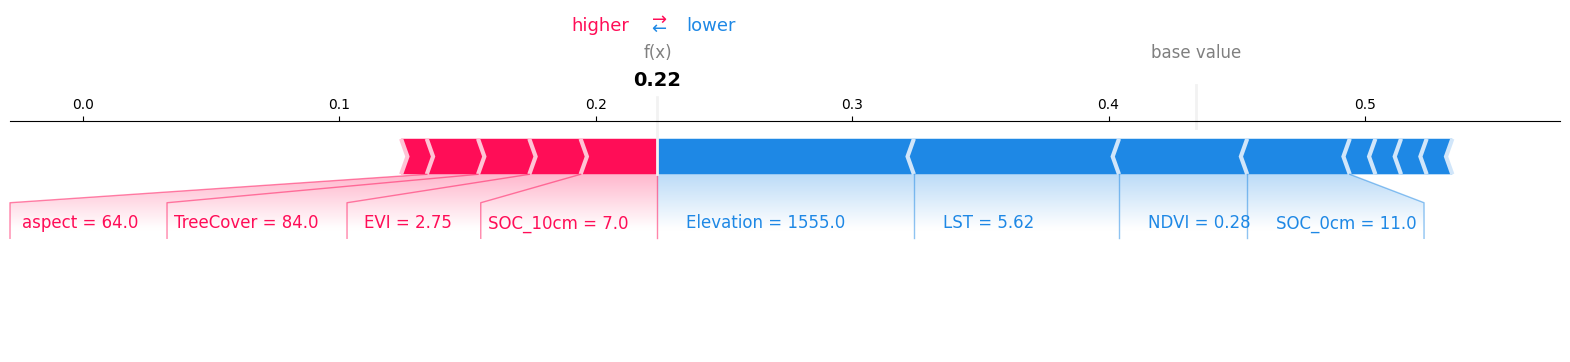

📌 Force plot saved: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots\shap_force_plot_sample_2.png


<Figure size 640x480 with 0 Axes>

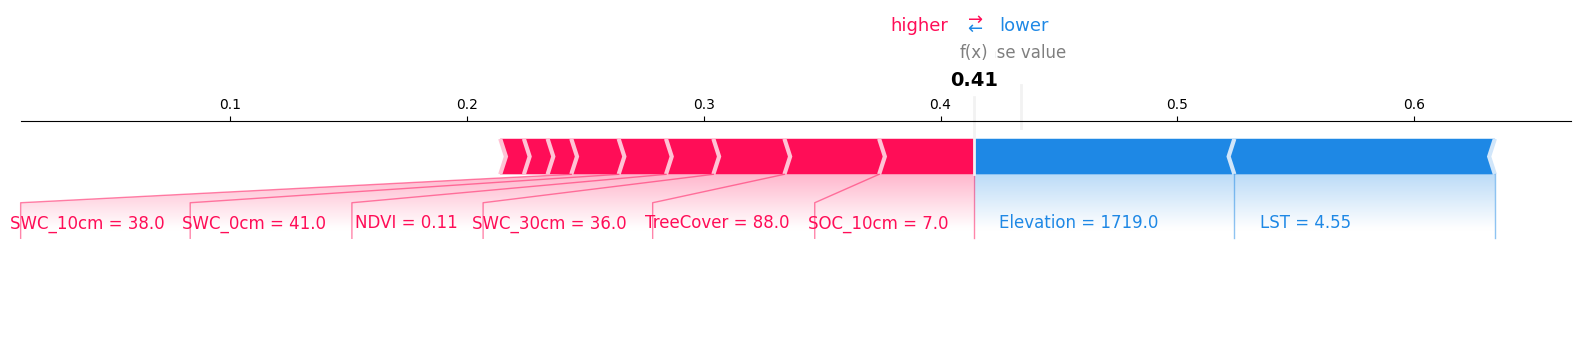

📌 Force plot saved: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots\shap_force_plot_sample_3.png


<Figure size 640x480 with 0 Axes>

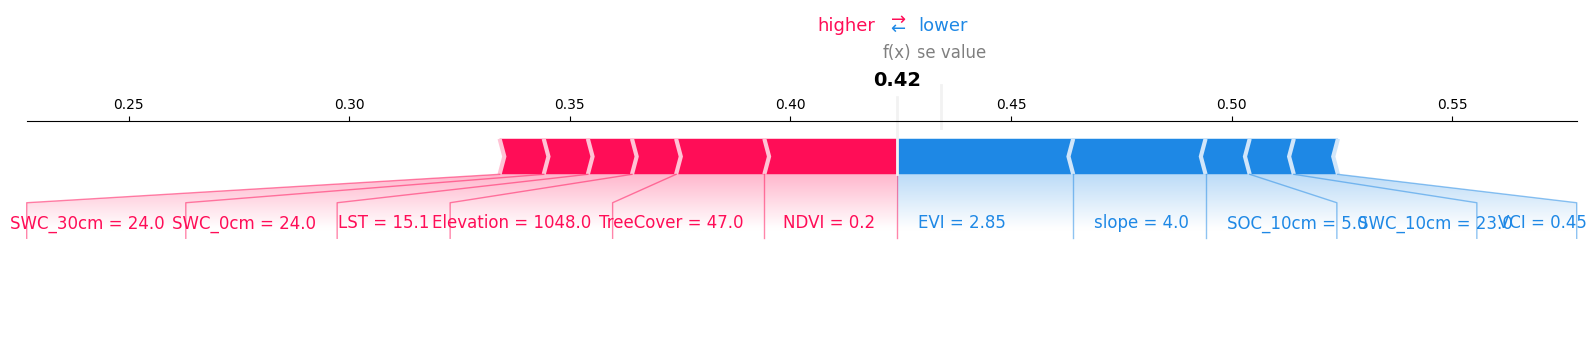

📌 Force plot saved: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots\shap_force_plot_sample_4.png


<Figure size 640x480 with 0 Axes>

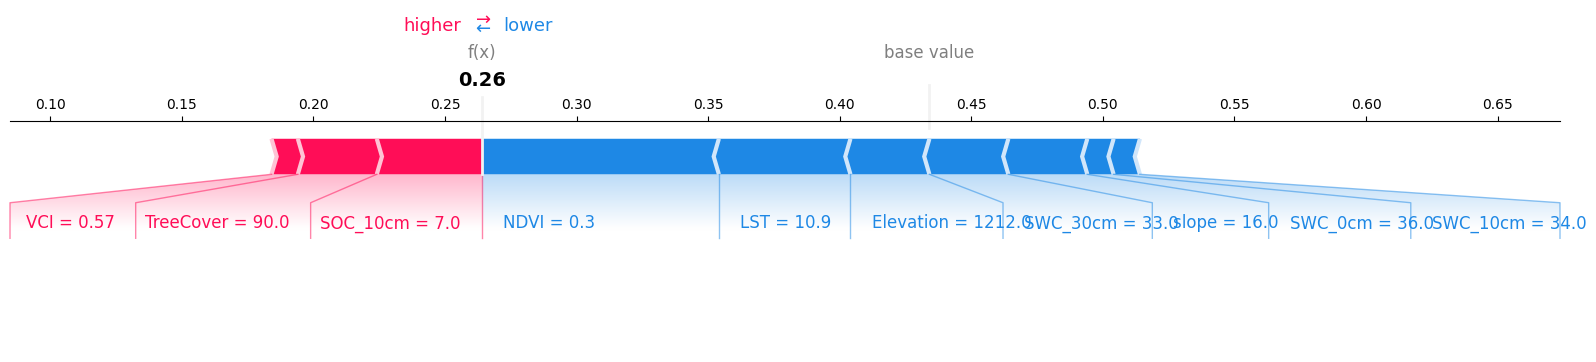

📌 Force plot saved: F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots\shap_force_plot_sample_5.png


In [5]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

# 1. Load training data
df = pd.read_csv("F:\Freelancing\WildFire_Paper_CA\GEE\Fire_Risk_CA_2025\FireRisk_Training_Samples.csv")
df = df.drop(columns=['system:index', '.geo'], errors='ignore')

# 2. Split features and labels
X = df.drop(columns=['class'])
y = df['class']

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 5. Use SHAP TreeExplainer (faster & optimized for RF)
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)  # list of arrays: [class0, class1]

# Confirm shape
print(f"✅ SHAP shape: {np.array(shap_values).shape}")  # Should be (2, n_samples, n_features)
print(f"✅ X_test shape: {X_test.shape}")

# Select SHAP values for class 1 (Fire)
shap_class1 = shap_values[:, :, 1]  # Shape (116, 15)

# Now plot
shap.summary_plot(
    shap_class1,
    features=X_test,
    feature_names=X.columns,
    plot_type='bar',
    show=False
)


plt.title("SHAP Feature Importance (Bar) - Random Forest")
plt.tight_layout()
bar_path = r"F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/shap_feature_importance_bar_RF.png"
plt.savefig(bar_path, dpi=300)
plt.close()
print(f"📊 SHAP bar plot saved to: {bar_path}")

# ✅ Save SHAP feature importance to CSV
mean_abs_shap = pd.DataFrame({
    "Feature": X.columns,
    "Mean_Abs_SHAP": np.abs(shap_class1).mean(axis=0)
}).sort_values(by="Mean_Abs_SHAP", ascending=False)

csv_path = r"F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/shap_feature_importance_RF.csv"
mean_abs_shap.to_csv(csv_path, index=False)
print(f"✅ SHAP feature importance saved to: {csv_path}")

# ✅ Optional summary plot (Bee Swarm)
shap.summary_plot(
    shap_class1,
    features=X_test,
    feature_names=X.columns
)


# === SHAP Force Plots (Top 5 Samples) ===
force_dir = r"F:/Freelancing/WildFire_Paper_CA/Excels_Results_1/SHAP_ForcePlots"
os.makedirs(force_dir, exist_ok=True)

for i in range(5):
    plt.figure()
    shap.force_plot(
        explainer.expected_value[1],
        np.round(shap_class1[i, :], 2),       # ✅ SHAP values rounded to 2 decimals
        np.round(X_test.iloc[i, :], 2),       # ✅ Feature values rounded to 2 decimals
        feature_names=X.columns,
        matplotlib=True
    )
    plt.title(f"SHAP Force Plot - Sample {i+1}")
    plt.tight_layout()
    force_path = os.path.join(force_dir, f"shap_force_plot_sample_{i+1}.png")
    plt.savefig(force_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"📌 Force plot saved: {force_path}")